Using device: cuda
Classes: ['Low Potential Dysgraphia', 'Potential Dysgraphia']
Class distribution: {'Low Potential Dysgraphia': 135, 'Potential Dysgraphia': 114}
Dataset sizes: Train=174, Val=37, Test=38

Displaying sample images:


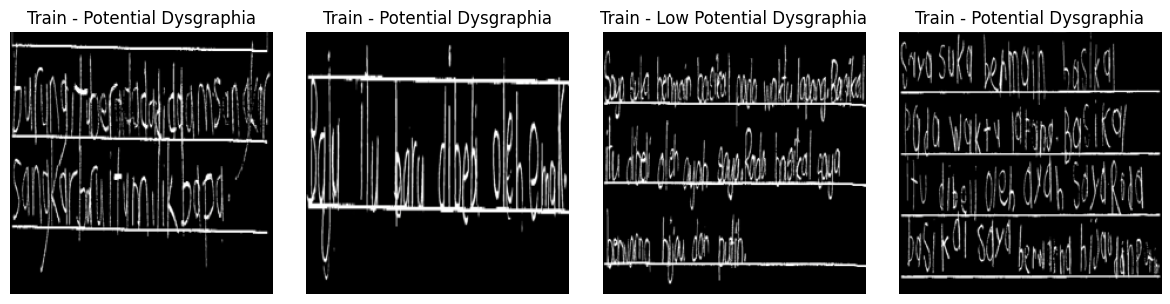

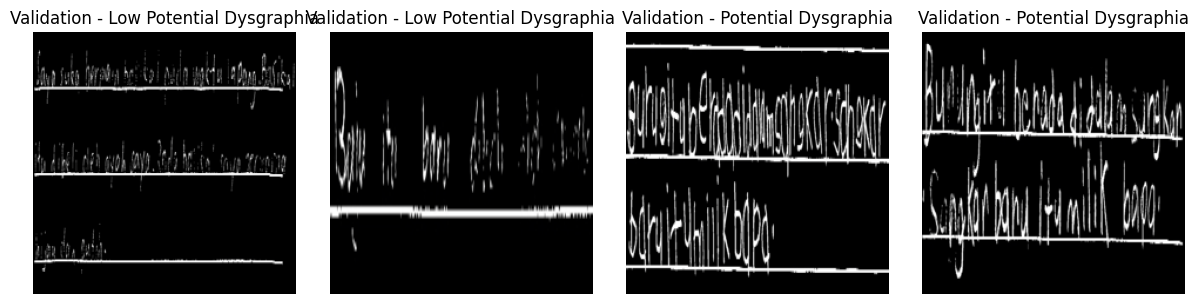

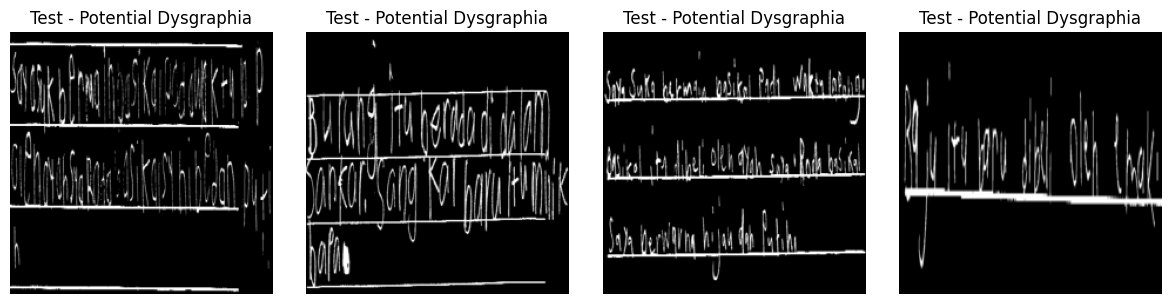

Training MobileNetV3-Small model...
Epoch 1/100 | Train Acc: 0.5805 | Val Acc: 0.5405 | Val Loss: 0.7330
Epoch 2/100 | Train Acc: 0.6724 | Val Acc: 0.7838 | Val Loss: 0.7054
Epoch 3/100 | Train Acc: 0.7414 | Val Acc: 0.8378 | Val Loss: 0.6728
Epoch 4/100 | Train Acc: 0.7989 | Val Acc: 0.8378 | Val Loss: 0.6315
Epoch 5/100 | Train Acc: 0.7701 | Val Acc: 0.8108 | Val Loss: 0.5946
Epoch 6/100 | Train Acc: 0.8161 | Val Acc: 0.8378 | Val Loss: 0.5657
Epoch 7/100 | Train Acc: 0.8391 | Val Acc: 0.8378 | Val Loss: 0.5366
Epoch 8/100 | Train Acc: 0.8391 | Val Acc: 0.8649 | Val Loss: 0.5132
Epoch 9/100 | Train Acc: 0.8046 | Val Acc: 0.8649 | Val Loss: 0.4988
Epoch 10/100 | Train Acc: 0.8333 | Val Acc: 0.8649 | Val Loss: 0.4845
Epoch 11/100 | Train Acc: 0.8506 | Val Acc: 0.8919 | Val Loss: 0.4723
Epoch 12/100 | Train Acc: 0.8793 | Val Acc: 0.8919 | Val Loss: 0.4616
Epoch 13/100 | Train Acc: 0.8506 | Val Acc: 0.8919 | Val Loss: 0.4528
Epoch 14/100 | Train Acc: 0.8851 | Val Acc: 0.8649 | Val Loss: 

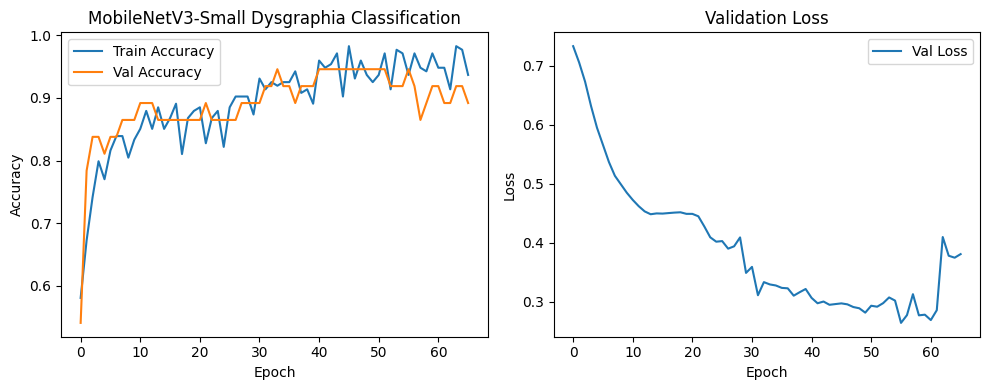


Evaluating on test set...
Test Metrics: Accuracy=2.1053, Precision=0.9286, Recall=0.7222, F1=0.8125

Prediction: Low Potential Dysgraphia
Confidence (Probability of Potential Dysgraphia): 0.0872
Similarity to dataset classes:
  Low Potential Dysgraphia: 0.3128
  Potential Dysgraphia: 0.1695


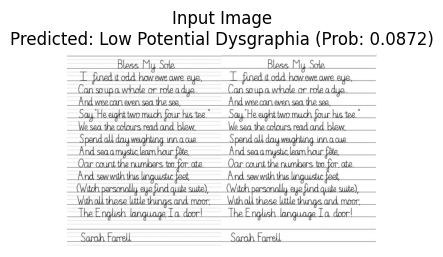


Prediction: Potential Dysgraphia
Confidence (Probability of Potential Dysgraphia): 0.9787
Similarity to dataset classes:
  Low Potential Dysgraphia: 0.2839
  Potential Dysgraphia: 0.4239


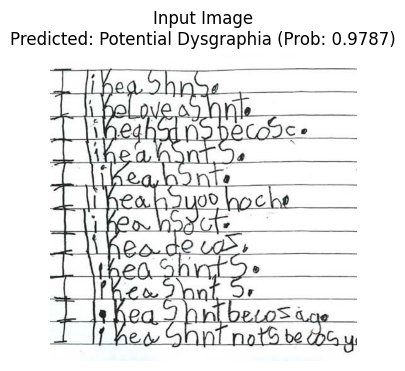

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter

# 🔧 Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 📂 Paths
base_dir = "C:/Users/aksha/OneDrive/Desktop/DATASET DYSGRAPHIA HANDWRITING"
model_path = "best_mobilenet_v3_small_dysgraphia.pth"

# 📸 Transformations
IMG_SIZE = 224
BATCH_SIZE = 4

# Enhanced training transforms for dysgraphia
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(40),  # Increased for dysgraphic variability
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.7, 1.3)),
    transforms.RandomErasing(p=0.7, scale=(0.02, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Add distortion
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 📦 Load dataset
train_dataset = datasets.ImageFolder(base_dir, transform=train_transform)
val_test_dataset = datasets.ImageFolder(base_dir, transform=val_test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

# Check class distribution
class_counts = Counter(train_dataset.targets)
print("Class distribution:", {class_names[k]: v for k, v in class_counts.items()})

# 🔀 Train/val/test split (70/15/15)
total_size = len(train_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_data, val_data, test_data = random_split(train_dataset, [train_size, val_size, test_size])

val_data.dataset.transform = val_test_transform
test_data.dataset.transform = val_test_transform

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print(f"Dataset sizes: Train={train_size}, Val={val_size}, Test={test_size}")

# 🖼️ Visualize images
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

def display_images(dataset, loader, split_name, num_images=4):
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, num_images, i+1)
        imshow(img, f"{split_name} - {class_names[label]}")
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images:")
display_images(train_data, train_loader, "Train")
display_images(val_data, val_loader, "Validation")
display_images(test_data, test_loader, "Test")

# 🧠 Define MobileNetV3-Small model
def create_model():
    model = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    # Unfreeze last 2 feature blocks
    for param in model.parameters():
        param.requires_grad = False
    for param in model.features[-2:].parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),  # Reduced slightly
        nn.Linear(128, 1)
    )
    return model.to(device)

# ⚙️ Temperature-scaled loss
class TemperatureScaledBCEWithLogitsLoss(nn.Module):
    def __init__(self, temperature=1.5, pos_weight=None):
        super(TemperatureScaledBCEWithLogitsLoss, self).__init__()
        self.temperature = temperature
        self.pos_weight = pos_weight

    def forward(self, input, target):
        input_scaled = input / self.temperature
        return nn.functional.binary_cross_entropy_with_logits(
            input_scaled, target, pos_weight=self.pos_weight
        )

# 🚀 Training loop
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=100):
    train_acc, val_acc, val_losses = [], [], []
    best_val_loss = float('inf')
    patience = 10

    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.sigmoid(outputs) > 0.6  # Adjusted threshold
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            train_loss += loss.item()

        train_accuracy = correct / total
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                preds = torch.sigmoid(outputs) > 0.6
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_loss += loss.item()

        val_accuracy = correct / total
        val_loss_avg = val_loss / len(val_loader)
        val_acc.append(val_accuracy)
        val_losses.append(val_loss_avg)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} | Val Loss: {val_loss_avg:.4f}")

        scheduler.step()

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), model_path)
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

    return train_acc, val_acc, val_losses

# 🏋️ Train model
def train():
    model = create_model()
    class_weights = torch.tensor([max(1.0, class_counts[0] / class_counts[1])]).to(device)  # Balanced weighting
    criterion = TemperatureScaledBCEWithLogitsLoss(temperature=1.5, pos_weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

    train_acc, val_acc, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("MobileNetV3-Small Dysgraphia Classification")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

# 🔍 Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

# 📊 Compute dataset features
def compute_dataset_features(model, dataset_path):
    dataset = datasets.ImageFolder(dataset_path, transform=val_test_transform)
    loader = DataLoader(dataset, batch_size=8, shuffle=False)
    class_names = dataset.classes
    feature_dict = {class_names[0]: [], class_names[1]: []}
    
    extractor = FeatureExtractor(model).to(device)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            features = extractor(images)
            for feat, label in zip(features, labels):
                feature_dict[class_names[label.item()]].append(feat.cpu().numpy())
    
    for cls in feature_dict:
        feature_dict[cls] = np.array(feature_dict[cls])
    return feature_dict, class_names

# 🔮 Predict dysgraphia
def predict_dysgraphia(model, image_path, dataset_path):
    original_image, image_tensor = load_image(image_path)
    
    with torch.no_grad():
        output = model(image_tensor)
        raw_prob = torch.sigmoid(output).item()
    
    # Temperature scaling applied during training, so use raw_prob directly
    prob = raw_prob
    prediction = 'Potential Dysgraphia' if prob > 0.6 else 'Low Potential Dysgraphia'
    
    extractor = FeatureExtractor(model).to(device)
    with torch.no_grad():
        input_features = extractor(image_tensor).cpu().numpy()
    
    feature_dict, class_names = compute_dataset_features(model, dataset_path)
    similarities = {}
    for cls in class_names:
        if len(feature_dict[cls]) > 0:
            sim = cosine_similarity(input_features, feature_dict[cls]).mean()
            similarities[cls] = sim
        else:
            similarities[cls] = 0.0
    
    print(f"\nPrediction: {prediction}")
    print(f"Confidence (Probability of Potential Dysgraphia): {prob:.4f}")
    print("Similarity to dataset classes:")
    for cls, sim in similarities.items():
        print(f"  {cls}: {sim:.4f}")
    
    if prediction == 'Potential Dysgraphia' and prob > 0.8:
        if similarities['Low Potential Dysgraphia'] > similarities['Potential Dysgraphia']:
            print("Warning: High confidence for Potential Dysgraphia, but similarity suggests Low Potential Dysgraphia.")
    elif prediction == 'Low Potential Dysgraphia' and prob < 0.2:
        if similarities['Potential Dysgraphia'] > similarities['Low Potential Dysgraphia']:
            print("Warning: High confidence for Low Potential Dysgraphia, but similarity suggests Potential Dysgraphia.")
    if 0.4 < prob < 0.6:
        print("Warning: Low confidence prediction. Result may be unreliable.")
    if max(similarities.values()) < 0.4:
        print("Warning: Low similarity to dataset. Input may not match training data.")

    plt.figure(figsize=(4, 4))
    plt.imshow(original_image)
    plt.title(f"Input Image\nPredicted: {prediction} (Prob: {prob:.4f})")
    plt.axis('off')
    plt.show()

# 📷 Load image
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image {image_path} does not exist")
    image = Image.open(image_path).convert('RGB')
    image_tensor = val_test_transform(image).unsqueeze(0)
    return image, image_tensor.to(device)

# 🧪 Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.6).astype(int)
            correct += (preds == labels.numpy()).sum()
            total += labels.size(0)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    print(f"Test Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    return accuracy, precision, recall, f1

# 🎯 Main execution
def main():
    print("Training MobileNetV3-Small model...")
    model = train()
    
    print("\nEvaluating on test set...")
    evaluate_model(model, test_loader)
    
    while True:
        image_path = input("\nEnter the path to the new handwriting image (or 'quit' to exit): ").strip()
        if image_path.lower() == 'quit':
            break
        try:
            predict_dysgraphia(model, image_path, base_dir)
        except Exception as e:
            print(f"Error processing image: {e}")

if __name__ == "__main__":
    main()

In [2]:
pip install flask torch torchvision pillow numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.cuda.is_available())  # Should print True if CUDA is set up

True
